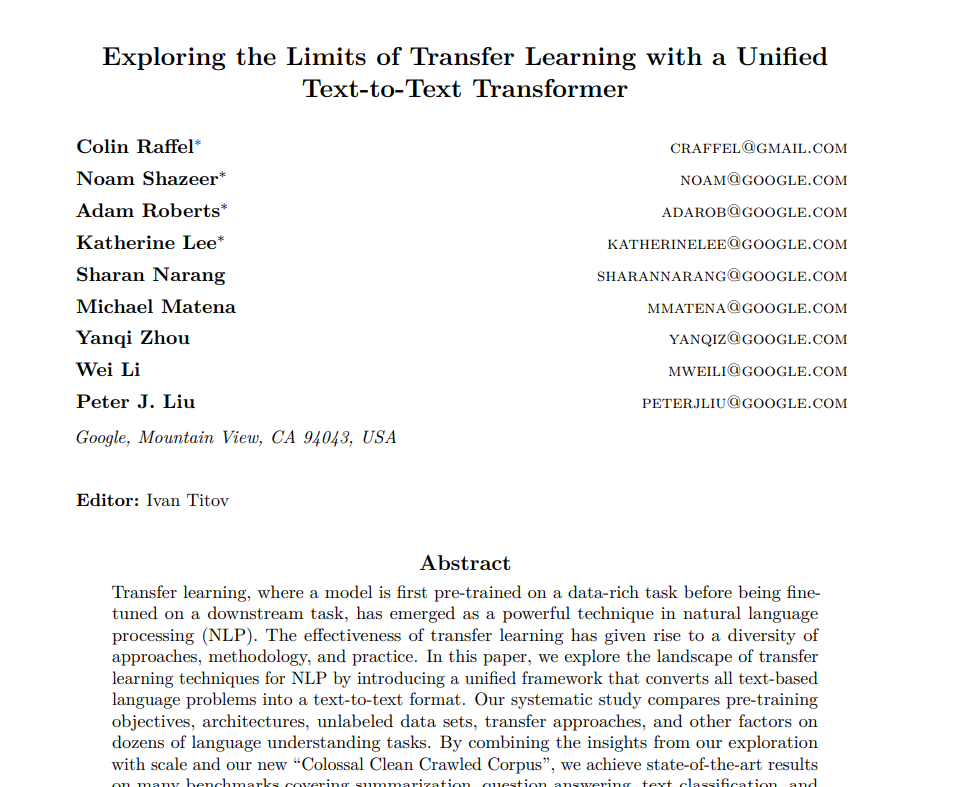

In [ ]:
%%capture
!pip install transformers[torch]
!pip install rouge_score

In [ ]:
from datasets import load_dataset, load_metric
from transformers import T5Tokenizer, T5ForConditionalGeneration, Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq
import numpy as np

In [ ]:
from datasets import load_dataset
dataset = load_dataset("multi_news")

The repository for multi_news contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/multi_news.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/44972 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5622 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5622 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['document', 'summary'],
        num_rows: 44972
    })
    validation: Dataset({
        features: ['document', 'summary'],
        num_rows: 5622
    })
    test: Dataset({
        features: ['document', 'summary'],
        num_rows: 5622
    })
})

In [ ]:
dataset['train'].features

{'document': Value(dtype='string', id=None),
 'summary': Value(dtype='string', id=None)}

In [ ]:
# Taking the subset of the dataset for the finetuning purpose
train_subset = dataset["train"].select(range(10000))
validation_subset = dataset["validation"].select(range(1000))
test_subset = dataset["test"].select(range(1000))

In [ ]:
checkpoint = 't5-small'
tokenizer = T5Tokenizer.from_pretrained(checkpoint)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
def preprocess_function(examples):
    inputs = ["summarize: " + doc for doc in examples["document"]]
    model_inputs = tokenizer(inputs, max_length=512, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["summary"], max_length=150, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
# Tokenize datasets
tokenized_train = train_subset.map(preprocess_function, batched=True)
tokenized_validation = validation_subset.map(preprocess_function, batched=True)
tokenized_test = test_subset.map(preprocess_function, batched=True)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3946: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
# Load Model
model = T5ForConditionalGeneration.from_pretrained(checkpoint)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
# Data collator
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# ROUGE Metrics

ROUGE (Recall-Oriented Understudy for Gisting Evaluation) is a set of metrics used to evaluate the quality of summaries by comparing them to reference summaries (typically human-generated). ROUGE is particularly popular in the field of natural language processing for tasks such as summarization. The metrics focus on different aspects of the generated summary and provide insights into its quality. The main ROUGE metrics include:

## ROUGE-N
Measures the overlap of n-grams between the candidate summary and the reference summary. The most common versions are ROUGE-1 (unigrams) and ROUGE-2 (bigrams).

### ROUGE-1
Counts the overlap of single words.
- **ROUGE-1 Recall**:
  $$
  \text{ROUGE-1 Recall} = \frac{\text{Number of overlapping unigrams}}{\text{Total unigrams in reference summary}}
  $$
- **ROUGE-1 Precision**:
  $$
  \text{ROUGE-1 Precision} = \frac{\text{Number of overlapping unigrams}}{\text{Total unigrams in candidate summary}}
  $$
- **ROUGE-1 F1-Score**:
  $$
  \text{ROUGE-1 F1-Score} = 2 \times \frac{\text{ROUGE-1 Recall} \times \text{ROUGE-1 Precision}}{\text{ROUGE-1 Recall} + \text{ROUGE-1 Precision}}
  $$

**Example Calculation for ROUGE-1:**

Given a reference summary "The cat sat on the mat." and a candidate summary "The cat is on the mat.", calculate ROUGE-1:
- Unigrams in Reference: {The, cat, sat, on, the, mat}
- Unigrams in Candidate: {The, cat, is, on, the, mat}
- Overlap: {The, cat, on, the, mat}
- Recall: $ \frac{5}{6} $
- Precision: $ \frac{5}{6} $
- F1-Score: $ 2 \times \frac{5/6 \times 5/6}{5/6 + 5/6} = 0.833 $

### ROUGE-2
Counts the overlap of two-word sequences.
- **ROUGE-2 Recall**:
  $$
  \text{ROUGE-2 Recall} = \frac{\text{Number of overlapping bigrams}}{\text{Total bigrams in reference summary}}
  $$
- **ROUGE-2 Precision**:
  $$
  \text{ROUGE-2 Precision} = \frac{\text{Number of overlapping bigrams}}{\text{Total bigrams in candidate summary}}
  $$
- **ROUGE-2 F1-Score**:
  $$
  \text{ROUGE-2 F1-Score} = 2 \times \frac{\text{ROUGE-2 Recall} \times \text{ROUGE-2 Precision}}{\text{ROUGE-2 Recall} + \text{ROUGE-2 Precision}}
  $$

**Example Calculation for ROUGE-2:**

Using the same reference and candidate summaries:
- Bigrams in Reference: {The cat, cat sat, sat on, on the, the mat}
- Bigrams in Candidate: {The cat, cat is, is on, on the, the mat}
- Overlap: {The cat, on the, the mat}
- Recall: $ \frac{3}{5} = 0.600 $
- Precision: $ \frac{3}{5} = 0.600 $
- F1-Score: $ 2 \times \frac{0.6 \times 0.6}{0.6 + 0.6} = 0.600 $

## ROUGE-L
Measures the longest common subsequence (LCS) between the candidate and reference summaries. This captures the longest sequence of words that appear in both summaries in the same order, reflecting the importance of sentence-level structure.
- **ROUGE-L Recall**:
  $$
  \text{ROUGE-L Recall} = \frac{\text{LCS}}{\text{Total words in reference summary}}
  $$
- **ROUGE-L Precision**:
  $$
  \text{ROUGE-L Precision} = \frac{\text{LCS}}{\text{Total words in candidate summary}}
  $$
- **ROUGE-L F1-Score**:
  $$
  \text{ROUGE-L F1-Score} = 2 \times \frac{\text{ROUGE-L Recall} \times \text{ROUGE-L Precision}}{\text{ROUGE-L Recall} + \text{ROUGE-L Precision}}
  $$

**Example Calculation for ROUGE-L:**

Using the same reference and candidate summaries:
- LCS: "The cat on the mat"
- Recall: $ \frac{5}{6} \approx 0.833 $
- Precision: $ \frac{5}{6} \approx 0.833 $
- F1-Score: $ 2 \times \frac{0.833 \times 0.833}{0.833 + 0.833} = 0.833 $


In [ ]:
# Define compute_metrics function
rouge = load_metric("rouge")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # Decode the predictions and labels
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    # Compute ROUGE scores
    rouge_output = rouge.compute(predictions=pred_str, references=label_str, use_stemmer=True)

    # Aggregate the ROUGE scores
    result = {key: value.mid.fmeasure * 100 for key, value in rouge_output.items()}
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in pred_ids]
    result["gen_len"] = np.mean(prediction_lens)

    return result

<ipython-input-28-4530d48ffbe8>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = load_metric("rouge")


The repository for rouge contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/rouge.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


In [ ]:
# Seq2Seq training arguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./results",             # Directory to save model checkpoints and logs
    evaluation_strategy="epoch",        # Evaluate the model at the end of each epoch
    learning_rate=2e-5,                 # Learning rate for the optimizer
    per_device_train_batch_size=16,     # Batch size for training
    per_device_eval_batch_size=16,      # Batch size for evaluation
    weight_decay=0.01,                  # Weight decay for regularization
    save_total_limit=3,                 # Limit the total number of checkpoints saved
    num_train_epochs=3,                 # Number of training epochs
    predict_with_generate=True,         # Use generation mode for prediction
    generation_max_length=150,          # Maximum length for generated sequences
    generation_num_beams=4,             # Number of beams for beam search during generation
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
## Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model=model,                       # The model to be trained
    args=training_args,                # Training arguments defined with Seq2SeqTrainingArguments
    train_dataset=tokenized_train,     # The training dataset
    eval_dataset=tokenized_validation, # The evaluation dataset
    data_collator=data_collator,       # The data collator for processing data batches
    tokenizer=tokenizer,               # The tokenizer used for preprocessing
    compute_metrics=compute_metrics,   # The function to compute evaluation metrics
)

In [ ]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,3.526400,3.052274,35.340917,10.794123,20.172807,20.158943,135.516000
2,3.262300,3.009547,36.104971,11.176360,20.675126,20.665258,138.058000
3,3.229600,2.998999,36.339588,11.333256,20.717507,20.707634,138.521000


TrainOutput(global_step=1875, training_loss=3.317008072916667, metrics={'train_runtime': 2606.4701, 'train_samples_per_second': 11.51, 'train_steps_per_second': 0.719, 'total_flos': 4060254044160000.0, 'train_loss': 3.317008072916667, 'epoch': 3.0})

In [ ]:
# Evaluate the model on validation set
trainer.evaluate()

# Evaluate the model on test set
test_results = trainer.evaluate(eval_dataset=tokenized_test)

print(test_results)

{'eval_loss': 2.96382999420166, 'eval_rouge1': 36.584459149567515, 'eval_rouge2': 11.736709173164527, 'eval_rougeL': 21.0397507709592, 'eval_rougeLsum': 21.04230759364472, 'eval_gen_len': 138.336, 'eval_runtime': 385.5445, 'eval_samples_per_second': 2.594, 'eval_steps_per_second': 0.163, 'epoch': 3.0}


In [ ]:
import torch
# Select a specific data point from the test dataset
test_index = 0  # Change this index to the specific data point you want to summarize
example_text = dataset["test"][test_index]["document"]

# Preprocess the input text
input_text = "summarize: " + example_text
inputs = tokenizer.encode(input_text, return_tensors="pt", max_length=512, truncation=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inputs = inputs.to(device)
# Generate the summary
summary_ids = model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)

# Decode the generated summary
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

print("Original Text:\n", example_text)
print("\nGenerated Summary:\n", summary)

Original Text:
 GOP Eyes Gains As Voters In 11 States Pick Governors 
 
 Enlarge this image toggle caption Jim Cole/AP Jim Cole/AP 
 
 Voters in 11 states will pick their governors tonight, and Republicans appear on track to increase their numbers by at least one, with the potential to extend their hold to more than two-thirds of the nation's top state offices. 
 
 Eight of the gubernatorial seats up for grabs are now held by Democrats; three are in Republican hands. Republicans currently hold 29 governorships, Democrats have 20, and Rhode Island's Gov. Lincoln Chafee is an Independent. 
 
 Polls and race analysts suggest that only three of tonight's contests are considered competitive, all in states where incumbent Democratic governors aren't running again: Montana, New Hampshire and Washington. 
 
 While those state races remain too close to call, Republicans are expected to wrest the North Carolina governorship from Democratic control, and to easily win GOP-held seats in Utah, North